In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
# module_path = os.path.abspath(os.path.join('../../src/twoDimensionalSPH'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
    

In [2]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
from BasisConvolution.twoDimensionalSPH.deltaSPH import deltaSPHSimulation
from BasisConvolution.twoDimensionalSPH.dfsph import dfsphSimulation

def loadConfig(config):
    with open(config, 'r') as file:
        tomlConfig = file.read()
    parsedConfig = tomli.loads(tomlConfig)
    simulationScheme = 'deltaSPH'
    if 'simulation' in parsedConfig:
        if 'scheme' in parsedConfig['simulation']:
            simulationScheme = parsedConfig['simulation']['scheme']
            
    if simulationScheme == 'deltaSPH' or simulationScheme == 'deltaPlus':
        return parsedConfig, deltaSPHSimulation
    if simulationScheme == 'dfsph':
        return parsedConfig, dfsphSimulation
    

/home/winchenbach/dev/SFBC/src/twoDimensionalSPH/deltaSPH.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm
Using /home/winchenbach/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/winchenbach/.cache/torch_extensions/py310_cu121/neighborSearch/build.ninja...
Building extension module neighborSearch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module neighborSearch...


In [4]:
import seaborn as sns
from BasisConvolution.twoDimensionalSPH.util import evalArea
from eval.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from scipy import interpolate
from BasisConvolution.twoDimensionalSPH.modules.neighborSearch import radiusCompactHashMap, periodicNeighborSearch
from BasisConvolution.twoDimensionalSPH.util import scatter_sum
from BasisConvolution.twoDimensionalSPH.kernels import *

In [5]:
def generatePeriodicRandomParticles(
    nx, minDomain = [-1,-1], maxDomain = [1,1], targetNeighbors = 20,
    noiseN = 256, noiseResolution = 2, noiseOctaves = 4,
    noiseLacunarity = 2, noisePersistance = 0.25, noiseSeed = 1337
):
    dx = (maxDomain[0] - minDomain[0]) / nx            
    area = dx**2
    area =  minimize(lambda r: evalArea(r[0], dx, torch.float32, 'cpu', targetNeighbors = targetNeighbors), area, method="nelder-mead", bounds =[(area * 1e-5,area *2)], tol = 1e-7).x[0]
    support = np.single(np.sqrt(area / np.pi * targetNeighbors))
    
    
    xx = np.linspace(minDomain[0] + dx / 2, maxDomain[0] - dx / 2, nx)
    yy = np.linspace(minDomain[1] + dx / 2, maxDomain[1] - dx / 2, nx)

    XX, YY = np.meshgrid(xx,yy)
    ptcls = np.stack((XX,YY), axis = 2).flatten().reshape((nx * nx, 2))
    
    xx, yy, noise = generateOctaveNoise(n = noiseN, baseFrequency = noiseResolution, \
                    octaves = noiseOctaves, lacunarity = noiseLacunarity, persistence = noisePersistance, \
                        seed = noiseSeed, kind = 'simplex')

# filtered = filterNoise(noise, minDomain, minCenter, boundary = self.config['generative']['boundaryWidth'], nd = np.array(self.config['generative']['nd']), n = self.config['generative']['n'], dh = 1e-2)
    noise = noise.numpy()
    noiseSampler = interpolate.RegularGridInterpolator((np.linspace(minDomain[0],maxDomain[0],noiseN), np.linspace(minDomain[1],maxDomain[1],noiseN)), noise, bounds_error = False, fill_value = None, method = 'linear')


    x = torch.tensor(ptcls).type(torch.float32)
    i, j, fluidDistances, fluidRadialDistances = periodicNeighborSearch(torch.tensor(ptcls).type(torch.float32), minDomain, maxDomain, support, True, True, True)

    rho = scatter_sum(area * kernel(fluidRadialDistances, support), i, dim = 0, dim_size = x.shape[0])

    potential = torch.tensor(noiseSampler((x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy()))).to(x.device).type(x.dtype)

    gradTerm = (area / rho[j]  *  (potential[j] - potential[i]))[:,None] * kernelGradient(fluidRadialDistances, fluidDistances, support)

    potentialGradient = scatter(gradTerm, i, dim=0, dim_size=x.size(0), reduce="add")

    velocities = torch.zeros_like(potentialGradient)
    velocities[:,0] = potentialGradient[:,1]
    velocities[:,1] = -potentialGradient[:,0]

    gterm = area / rho[j]  * torch.einsum('nd, nd -> n', velocities[j] - velocities[i], kernelGradient(fluidRadialDistances, fluidDistances, support))

    div = scatter(gterm, i, dim=0, dim_size=x.size(0), reduce="add")
    
    return x, dx, area, support, potential, rho, velocities, div

torch.Size([16384, 2])


/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


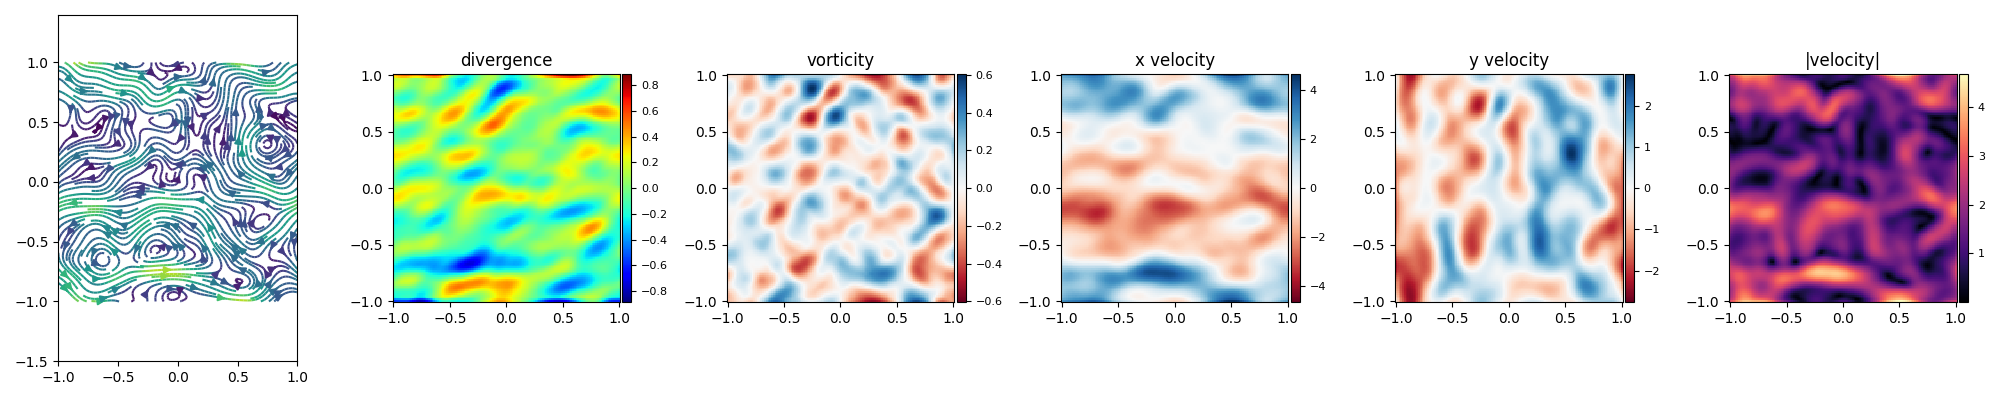

In [6]:

from BasisConvolution.twoDimensionalSPH.modules.neighborSearch import periodicNeighborSearchXY
from BasisConvolution.twoDimensionalSPH.kernels import kernel

positions, dx, area, support, potential, rho, velocities, div = generatePeriodicRandomParticles(128, noiseOctaves = 3, targetNeighbors = 27, noiseSeed = 1234, noiseResolution = 1, noisePersistance=0.5)


nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = 'cpu', dtype = positions.dtype)
print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, positions, 
                                                            np.array([-1,-1]), np.array([1,1]), 
                                                            support, 
                                                            True, True)


vel = scatter(velocities[i] * (area / rho[i] * kernel(radialDistances, support))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')

vel = velocities

fig, axis = plt.subplots(1, 6, figsize=(20,4), sharex = False, sharey = False, squeeze = False)
xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)
axis[0,0].set_aspect(1)
axis[0,0].axis('equal')
# fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc
def pMesh3(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'jet', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
divergence = np.gradient(xVel)[0] - np.gradient(xVel)[1]

pMeshV = pMesh3(fig,axis[0,1], xx, yy, divergence, 'divergence')
pMeshV = pMesh2(fig,axis[0,2], xx, yy, vorticity, 'vorticity')
pMeshX = pMesh2(fig,axis[0,3], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,4], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,5], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
# fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles']))

fig.tight_layout()

In [9]:
seeds = torch.randint(low = 0, high = 2**30, size = (36,1)).flatten().numpy().tolist()
print(seeds)

[7475362, 299214905, 255432275, 129520927, 630569140, 627336039, 104953240, 541573293, 220022023, 974598936, 914921413, 696354072, 1005592442, 15697394, 575526248, 449847242, 693155930, 126993595, 614513535, 1069446336, 346514241, 121298256, 1051568639, 164298505, 633036232, 780309973, 288195481, 450117195, 687108519, 12244874, 891038915, 189364830, 15608982, 920214843, 940289724, 263602499]


In [10]:
config = '../../datasets/configs/periodicDomain.toml'

with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

simulationModel = deltaSPHSimulation
# simulationModel = dfsphSimulation
for seed in tqdm(seeds):
    parsedConfig['generative']['seed'] = seed
    parsedConfig['generative']['prefix'] = 'generativePeriodic_base_1_octaves_3'
    sphSimulation = simulationModel(parsedConfig)
    sphSimulation.initializeSimulation()
    state = sphSimulation.simulationState
    state['fluidVelocity'] = 4.0 * state['fluidVelocity'] / torch.max(torch.linalg.norm(state['fluidVelocity'], dim = -1))
    timesteps = 4096 * 4
    for i in tqdm(range(timesteps),leave = False):
        sphSimulation.integrate()

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

generateSimplex 256 1 2 1234567 cpu torch.float32 True
generateSimplexP 256 1 2 1234567 cpu torch.float32 True
generateSimplex 256 2 2 1234567 cpu torch.float32 True
generateSimplexP 256 2 2 1234567 cpu torch.float32 True
generateSimplex 256 4 2 1234567 cpu torch.float32 True
generateSimplexP 256 4 2 1234567 cpu torch.float32 True
torch.Size([16384, 2])


/tmp/ipykernel_3970001/925767916.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axis = plt.subplots(1, 6, figsize=(20,4), sharex = False, sharey = False, squeeze = False)


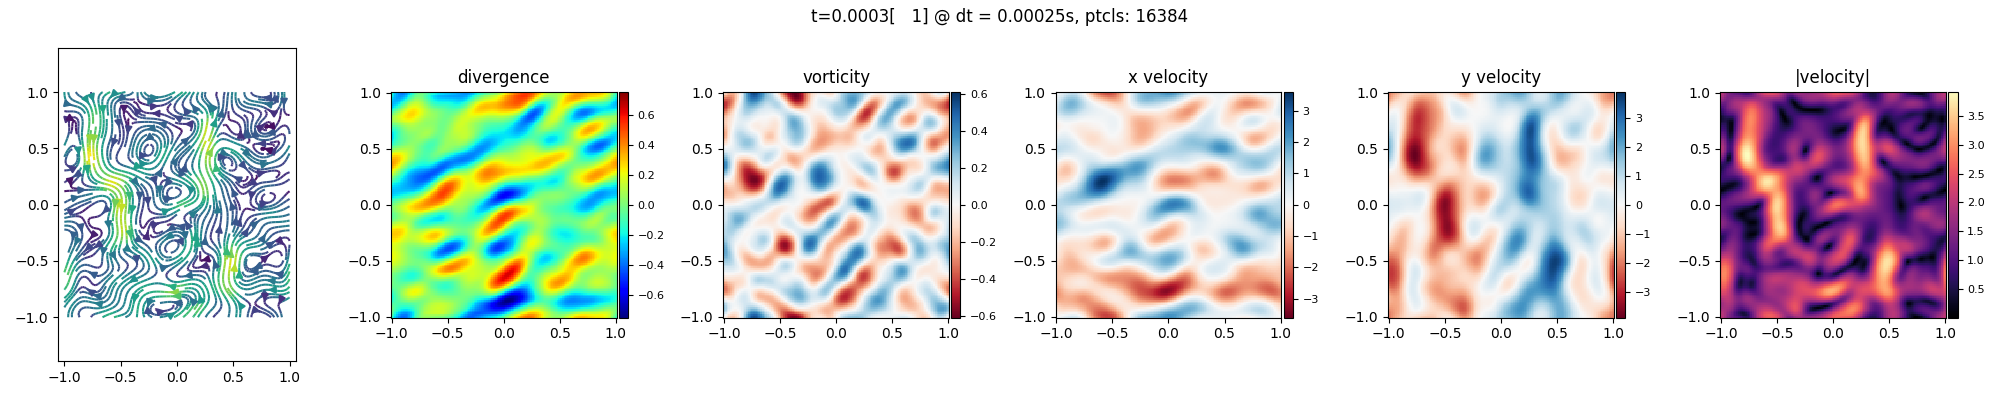

In [44]:
config = '../../datasets/configs/periodicDomain.toml'

with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

simulationModel = deltaSPHSimulation
# simulationModel = dfsphSimulation

sphSimulation = simulationModel(parsedConfig)
sphSimulation.initializeSimulation()
state = sphSimulation.simulationState
state['fluidVelocity'] = 4.0 * state['fluidVelocity'] / torch.max(torch.linalg.norm(state['fluidVelocity'], dim = -1))

# A = 1
# B = -1
# k = np.pi
# state['fluidVelocity'][:,0] =  4 * torch.cos(k * state['fluidPosition'][:,0]) * torch.sin(k * state['fluidPosition'][:,1])
# state['fluidVelocity'][:,1] = -4 * torch.sin(k * state['fluidPosition'][:,0]) * torch.cos(k * state['fluidPosition'][:,1])


sphSimulation.integrate()

from BasisConvolution.twoDimensionalSPH.modules.neighborSearch import periodicNeighborSearchXY
from BasisConvolution.twoDimensionalSPH.kernels import kernel

nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
# x = np.linspace(0,2*np.pi,nx)
# y = np.linspace(0,2*np.pi,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                            sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                            sphSimulation.config['particle']['support'], 
                                                            sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])


vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')

fig, axis = plt.subplots(1, 6, figsize=(20,4), sharex = False, sharey = False, squeeze = False)
xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)
# axis[0,0].set_xlim(0,2*np.pi)
# axis[0,0].set_ylim(0,2*np.pi)
axis[0,0].set_aspect(1)
axis[0,0].axis('equal')
# fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc
def pMesh3(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'jet', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
divergence = np.gradient(xVel)[0] - np.gradient(xVel)[1]

pMeshV = pMesh3(fig,axis[0,1], xx, yy, divergence, 'divergence')
pMeshV = pMesh2(fig,axis[0,2], xx, yy, vorticity, 'vorticity')
pMeshX = pMesh2(fig,axis[0,3], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,4], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,5], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles']))

fig.tight_layout()

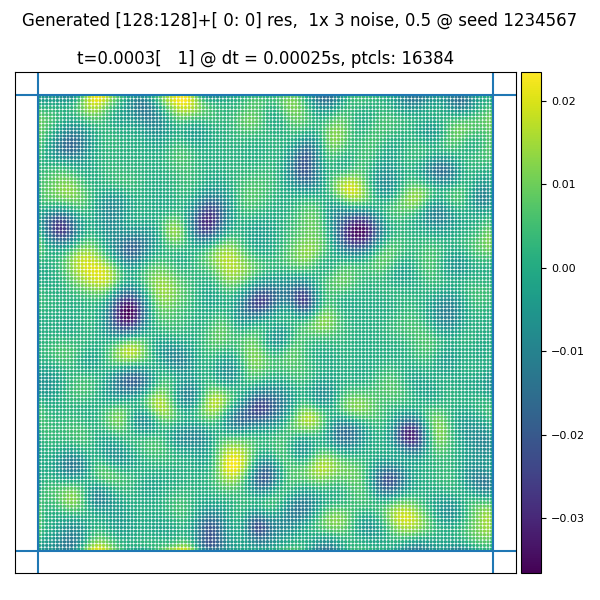

In [45]:
fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidPressure'].detach().cpu().numpy()
# data = ni.detach().cpu().numpy()

minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
y = np.remainder(positions - minD, maxD - minD) + minD

sc = axis[0,0].scatter(y[:,0], y[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(state['time'], state['timestep'], state['dt'],state['numParticles']))

axis[0,0].set_xlim(-1.1,1.1)
axis[0,0].set_ylim(-1.1,1.1)
axis[0,0].axvline(-1)
axis[0,0].axvline(1)
axis[0,0].axhline(-1)
axis[0,0].axhline(1)


fig.tight_layout()



(-1.0, 1.0, -1.0, 1.0)

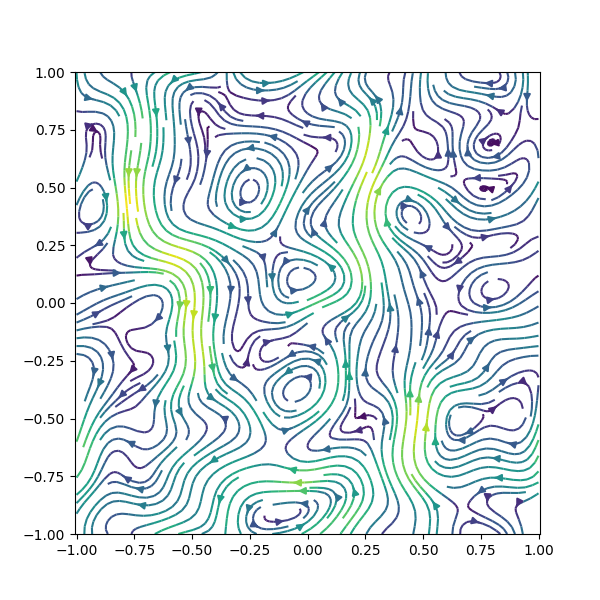

In [46]:

nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                            sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                            sphSimulation.config['particle']['support'], 
                                                            sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')

fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)
axis[0,0].set_aspect(1)
axis[0,0].axis('equal')

In [47]:
import seaborn as sns

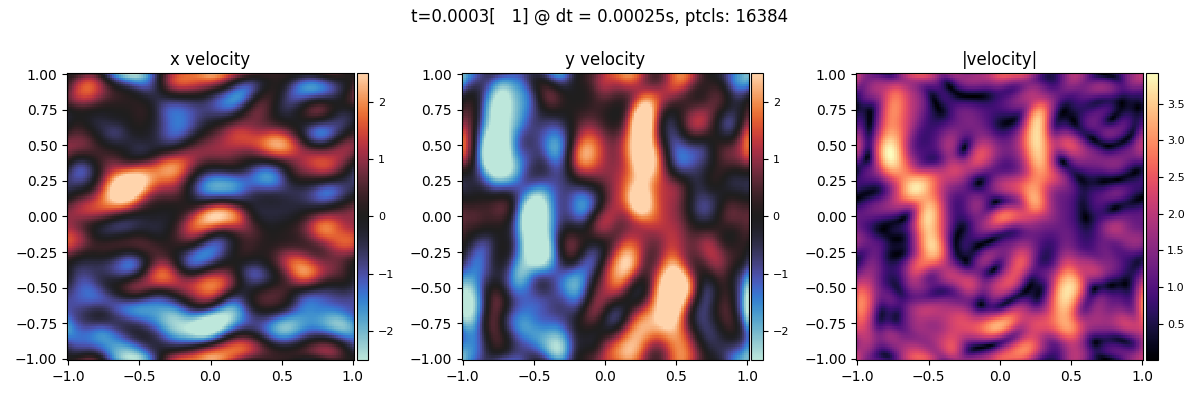

In [48]:

def updatePlot(sphSimulation, pMeshX, pMeshY, pMeshN, fig, axis):
    nx = 128
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,nx)
    xx, yy = np.meshgrid(x,y)
    pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
    i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                                sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                                sphSimulation.config['particle']['support'], 
                                                                sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

    vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')
    xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
    yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

    pMeshX.set_array(xVel)
    pMeshY.set_array(yVel)
    pMeshN.set_array(np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2))

    # axis[0,0].cla()
    # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
    # axis[0,0].set_xlim(-1,1)
    # axis[0,0].set_ylim(-1,1)
    axis[0,0].set_aspect(1)
    
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'vlag', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
    
pMeshX = pMesh2(fig,axis[0,0], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,1], xx, yy, yVel, 'y velocity')
pMeshN = pMesh(fig,axis[0,2], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles']))
        
fig.tight_layout()

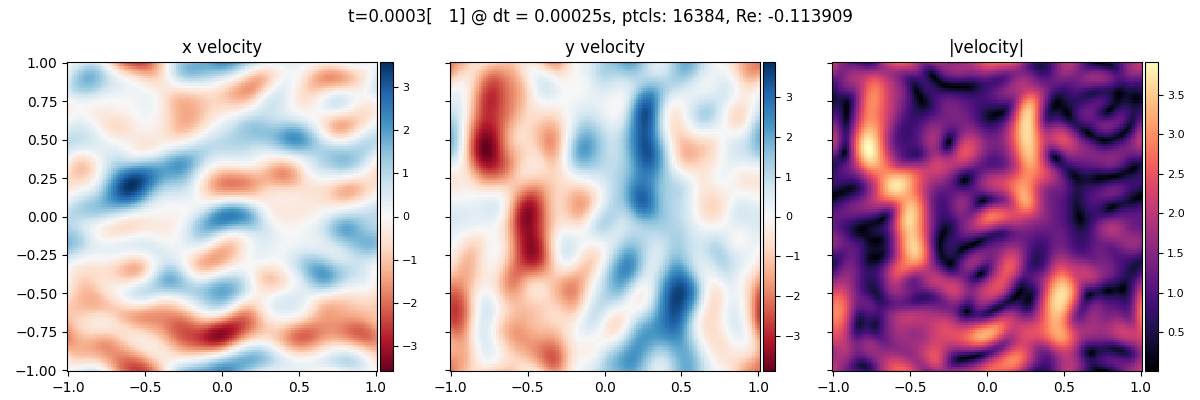

In [49]:

def updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis):
    nx = 128
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,nx)
    xx, yy = np.meshgrid(x,y)
    pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
    i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                                sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                                sphSimulation.config['particle']['support'], 
                                                                sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

    vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')
    xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
    yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

    vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]

    # pMeshV.set_array(vorticity)
    pMeshX.set_array(xVel)
    pMeshY.set_array(yVel)
    pMeshN.set_array(np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2))

        
    positions = state['fluidPosition'].detach().cpu().numpy()
    data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
    minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
    maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
    # y = np.remainder(positions - minD, maxD - minD) + minD
    # sc.set_offsets(np.c_[y[:,0], y[:,1]])
    # sc.set_array(data)

    nu = np.log(data.max()/4) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
    Re = data.max() * 2 / nu
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
    # axis[0,0].cla()
    # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
    # axis[0,0].set_xlim(-1,1)
    # axis[0,0].set_ylim(-1,1)
    # axis[0,0].set_aspect(1)
    
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]

# pMeshV = pMesh2(fig,axis[0,0], xx, yy, vorticity, 'vorticity')
positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
y = np.remainder(positions - minD, maxD - minD) + minD
# sc = axis[0,0].scatter(y[:,0], y[:,1], c = torch.linalg.norm(sphSimulation.simulationState['fluidVelocity'], dim = -1).cpu().numpy(), s = 1,cmap = 'magma')
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
# axis[0,0].set_box_aspect(1)
# axis[0,0].set_title('Particle |velocity|')

pMeshX = pMesh2(fig,axis[0,0], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,1], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,2], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
nu = np.log(data.max()) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
Re = data.max() * 2 / nu
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
        
fig.tight_layout()

In [50]:
nu = np.log(data.max()) /(-2 * np.pi**2 * sphSimulation.simulationState['time'])

In [51]:
data.max() * 2 / nu

-0.02847724800548691

In [52]:
np.log(data.max()/4) /(-2) / sphSimulation.simulationState['time']

0.10347634012215509

In [53]:
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
if not os.path.exists(path):
    os.makedirs(path)

In [54]:
timesteps = 4096 * 4
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        imagePath = path + '%05d.png' % state['timestep']
        plt.savefig(imagePath)

  0%|          | 0/16384 [00:00<?, ?it/s]

In [20]:
sphSimulation.simulationState['fluidNeighbors'], sphSimulation.simulationState['fluidDistances'], sphSimulation.simulationState['fluidRadialDistances'] = sphSimulation.neighborSearch.search(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryFilterNeighborhoods(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryNeighborhoodSearch(sphSimulation.simulationState, sphSimulation)

sphSimulation.sphDensity.evaluate(sphSimulation.simulationState, sphSimulation)    
sphSimulation.boundaryModule.evalBoundaryDensity(sphSimulation.simulationState, sphSimulation) 
sphSimulation.simulationState['fluidAcceleration'] = torch.zeros_like(sphSimulation.simulationState['fluidVelocity'])   
sphSimulation.gravityModule.evaluate(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['densityIterations'] = sphSimulation.DFSPH.incompressibleSolver(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['fluidAcceleration'] += sphSimulation.simulationState['fluidPredAccel']
sphSimulation.velocityDiffusionModule.evaluate(sphSimulation.simulationState, sphSimulation)    

fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)

fig.tight_layout()


AttributeError: 'solidBoundaryModule' object has no attribute 'boundaryToFluidNeighbors'

In [171]:
# print(sphSimulation.config['fluid'])

In [172]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = './outputCollision/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)

In [174]:
timesteps = 128
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 1 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState
        positions = state['fluidPosition'].detach().cpu().numpy()

#         positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
        
        data = state['fluidDensity'].detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy() * 0
        
#         data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
        data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
#         data = torch.linalg.norm(state['fluidUpdate'], dim=1).detach().cpu().numpy()
        
#         data = state['fluidPressure'].detach().cpu().numpy()
#         data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

#         positions = np.vstack((positions, positions2))
#         data = np.hstack((data, data2))

        cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        sc.set_offsets(positions)
        sc.set_array(data)


        axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
        if 'densityErrors' in state and not 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
        if 'divergenceErrors' in state and not 'densityErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
        if 'densityErrors' in state and 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
#         imagePath = path + '%05d.png' % state['timestep']
#         plt.savefig(imagePath)

  0%|          | 0/128 [00:00<?, ?it/s]

In [151]:
from BasisConvolution.modules.densityDiffusion import computeNormalizationMatrix
from BasisConvolution.kernels import kernel, spikyGrad, kernelGradient
simulationState = sphSimulation.simulationState
normalizationMatrix = computeNormalizationMatrix(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], simulationState['fluidPosition'], simulationState['fluidVolume'], simulationState['fluidVolume'],\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  sphSimulation.densityDiffusionModule.support, simulationState['fluidDensity'].shape[0], sphSimulation.densityDiffusionModule.eps)     
normalizationMatrix += sphSimulation.boundaryModule.computeNormalizationMatrices(simulationState, sphSimulation)
ni = simulationState['fluidNeighbors'][0]

In [171]:
def gj_solve(m=[1., 0.], n=3, nb=1, result=[0.0, 0.0]):
    r"""A gauss-jordan method to solve an augmented matrix.
    The routine is given the augmented matrix, the number of rows/cols in the
    original matrix and the number of added columns. The result is stored in
    the result array passed.
    Parameters
    ----------
    m : list: a flattened list representing the augmented matrix [A|b].
    n : int: number of columns/rows used from A in augmented_matrix.
    nb: int: number of columns added to A.
    result: list: with size n*nb
    References
    ----------
    https://ricardianambivalence.com/2012/10/20/pure-python-gauss-jordan
    -solve-ax-b-invert-a/
    """

    i, j, eqns, colrange, augCol, col, row, bigrow, nt = 0,0,0,0,0,0,0,0,0
    eqns = n
    colrange = n
    augCol = n + nb
    nt = n + nb

    for col in range(colrange):
        bigrow = col
        for row in range(col + 1, colrange):
            if abs(m[nt*row + col]) > abs(m[nt*bigrow + col]):
                bigrow = row
                temp = m[nt*row + col]
                m[nt*row + col] = m[nt*bigrow + col]
                m[nt*bigrow + col] = temp
    print(m.reshape(4,3))
    rr, rrcol, rb, rbr, kup, kupr, kleft, kleftr = 0,0,0,0,0,0,0,0
    for rrcol in range(0, colrange):
        for rr in range(rrcol + 1, eqns):
            dnr = float(m[nt*rrcol + rrcol])
            if abs(dnr) < 1e-12:
                return 1.0
            cc = -float(m[nt*rr + rrcol]) / dnr
            for j in range(augCol):
                m[nt*rr + j] = m[nt*rr + j] + cc * m[nt*rrcol + j]
    print(m.reshape(4,3))

    backCol, backColr = 0,0
    tol = 1.0e-12
    for rbr in range(eqns):
        rb = eqns - rbr - 1
        if (m[nt*rb + rb] == 0):
            if abs(m[nt*rb + augCol - 1]) > tol:
                # Error, singular matrix.
                return 1.0
        else:
            for backColr in range(rb, augCol):
                backCol = rb + augCol - backColr - 1
                m[nt*rb + backCol] = m[nt*rb + backCol] / m[nt*rb + rb]
            if not (rb == 0):
                for kupr in range(rb):
                    kup = rb - kupr - 1
                    for kleftr in range(rb, augCol):
                        kleft = rb + augCol - kleftr - 1
                        kk = -m[nt*kup + rb] / m[nt*rb + rb]
                        m[nt*kup + kleft] = (m[nt*kup + kleft] +
                                             kk * m[nt*rb + kleft])
    print(m.reshape(4,3))

    for i in range(n):
        for j in range(nb):
            result[nb*i + j] = m[nt*i + n + j]

    return 0.0

In [169]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
print(temp.reshape(ni.shape[0],4,3))
print(normalizationMatrix[ni])

torch.Size([286984, 9])
tensor([[[ 2.0370e+00, -1.1060e-02, -0.0000e+00],
         [-1.1061e-02,  2.0291e+00, -0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
         [-1.1061e-02,  2.0291e+00, -4.4629e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.0370e+00, -1.1060e-02,  6.0596e+03],
         [-1.1061e-02,  2.0291e+00,  2.3369e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        ...,

        [[ 8.5401e-01,  1.2634e-01, -1.9500e-03],
         [ 1.2634e-01,  1.1822e+00, -1.5179e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 8.5401e-01,  1.2634e-01, -2.3994e+00],
         [ 1.2634e-01,  1.1822e+00, -1.7218e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
    

In [99]:
batch_gj_solve(temp, n, 1, res)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [172]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
# print(temp.reshape(ni.shape[0],4,3))
# print(normalizationMatrix[ni])

gj_solve(temp[1], n, 1, res[1])
print(temp[1].reshape(4,3))
print(res[1])

torch.Size([286984, 9])
tensor([[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
        [-1.1061e-02,  2.0291e+00, -4.4629e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])
tensor([[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
        [ 0.0000e+00,  2.0291e+00,  2.6662e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])
tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [213]:
normalizationMatrix.device

device(type='cuda', index=0)

In [253]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_GJ(normalizationMatrix, gradW, ni)

In [254]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_PINV(normalizationMatrix, gradW, ni)

In [256]:
dwij_mag = torch.linalg.norm(gradW, axis = 1, ord = 1)
norm_mag = torch.linalg.norm(normalizedGradients, axis = 1, ord = 1)

eps = 1e-4 * sphSimulation.densityDiffusionModule.support
tol = 0.1
change = abs(norm_mag - dwij_mag) / (dwij_mag + eps)
normalizedGradients = torch.where((change < tol)[:,None], normalizedGradients, gradW)

# print(change)

In [192]:
print(m[1].reshape(4,3))
print(res[1])

tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [155]:
print(temp[1].reshape(4,3))
print(res[1])

tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [93]:
pinv = torch.linalg.pinv(normalizationMatrix[0])
print(normalizationMatrix[0])
print(pinv)
print(pinv * normalizationMatrix[0])
print(gradW[1])
print(torch.mv(pinv, gradW[1]))


tensor([[ 2.0370, -0.0111],
        [-0.0111,  2.0291]], device='cuda:0')
tensor([[0.4909, 0.0027],
        [0.0027, 0.4928]], device='cuda:0')
tensor([[ 1.0000e+00, -2.9597e-05],
        [-2.9599e-05,  1.0000e+00]], device='cuda:0')
tensor([13129.4355,   -44.6293], device='cuda:0')
tensor([6445.4526,   13.1392], device='cuda:0')


In [23]:
# debugPrint(sphSimulation.config['particle']['support'])
# debugPrint(sphSimulation.simulationState['fluidSupport'])

In [151]:
sphSimulation.outFile.close()
# debugPrint(sphSimulation.outFile.keys())

In [11]:
# fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)
# state = sphSimulation.simulationState

# positions = state['fluidPosition'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()

# positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

# # data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

# # positions = np.vstack((positions, positions2))
# # data = np.hstack((data, data2))

# # data = sphSimulation.DFSPH.fluidAlpha
# data = state['fluidPressure']

# # positions = positions2
# # data = data2

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# # quiverData = state['fluidUpdate'].detach().cpu().numpy()
# # qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
# #                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
# if 'densityErrors' in state and not 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
# if 'divergenceErrors' in state and not 'densityErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
# if 'densityErrors' in state and 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

# fig.tight_layout()



In [104]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.integrate()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          full Timestep         0.66%       2.732ms        98.52%     404.890ms     404.890ms          -4 b        -284 b       1.51 Mb     -76.14 Mb             1  
                                  9 - density diffusion         0.06%     237.000us        35.73%     146.846ms      36.712ms         -16 b        -548 b     855.50 Kb           0 b             4  
         